In [10]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from estimators import *
from helpers import *
sns.set_theme()

In [28]:
d = 1000
k = 20
epsilon = 0.5
sigma = 2.
num_buckets_hyperparam = 1

In [29]:
n = 1000
Rs = np.arange(10, 101, 10)

In [30]:
# set mu with d-k zero coordinates, and k coordinates drawn from Unif(1, 10)
mu = np.concatenate([np.random.uniform(low=-10, high=10, size=k),
                     np.zeros(d - k)])
np.random.shuffle(mu)
gen = generative_process('gaussian', mu=mu, sigma=sigma)

In [31]:
def get_fraction_mass_recovered(algo, R, n, sigma=sigma, num_rounds=10):
    l2_res = []
    for i in range(num_rounds):
        X = gen(n)
        estimate = algo(X, R=R, k=k,
                        epsilon=epsilon,
                        c=num_buckets_hyperparam,
                        alpha=1.,
                        sigma=sigma,
                        num_bins_uni_est=1)

        l2_res.append(np.linalg.norm(mu[estimate != 0]) / np.linalg.norm(mu))
    res = np.array(l2_res)
    return pd.DataFrame(np.stack([res, np.zeros_like(res) + R]).T,
                        columns=['fraction', 'R'])

In [32]:
def get_l2_error(algo, R, n, num_bins_uni_est=1, num_rounds=10):
    l2_res = []
    for i in range(num_rounds):
        X = gen(n)
        estimate = algo(X, R=R, k=k,
                        epsilon=epsilon,
                        c=num_buckets_hyperparam,
                        alpha=1.,
                        sigma=sigma,
                        num_bins_uni_est=num_bins_uni_est)

        l2_res.append(np.linalg.norm(mu - estimate))
    res = np.array(l2_res)
    return pd.DataFrame(np.stack([res, np.zeros_like(res) + R]).T,
                        columns=['l2_error', 'R'])

## Figure 1: support estimation

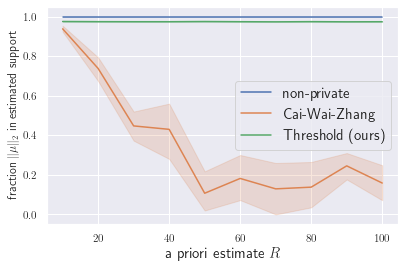

In [34]:
res_nonpriv = []
for R in Rs:
    res_nonpriv.append(get_fraction_mass_recovered(non_private_sparse_mean,
                                                   R, n))
res_nonpriv = pd.concat(res_nonpriv, ignore_index=True)
sns.lineplot(x='R', y='fraction',
             data=res_nonpriv,
             label='non-private')

res_cost_of_privacy = []
for R in Rs:
    res_cost_of_privacy.append(get_fraction_mass_recovered(cost_of_privacy_algorithm,
                                                           R, n))
res_cost_of_privacy = pd.concat(res_cost_of_privacy, ignore_index=True)
sns.lineplot(x='R', y='fraction',
             data=res_cost_of_privacy,
             label='Cai-Wai-Zhang')

res_thresholding = []
for R in Rs:
    res_thresholding.append(get_fraction_mass_recovered(thresholded_peeling,
                                                        R, n))
res_thresholding = pd.concat(res_thresholding, ignore_index=True)
sns.lineplot(x='R', y='fraction',
             data=res_thresholding,
             label='Threshold (ours)')

sns.set(font_scale=1, rc={'text.usetex' : True})
plt.xlabel('a priori estimate $R$', fontsize=15)
plt.ylabel('fraction $\|\mu\|_2$ in estimated support', fontsize=12)
plt.legend(fontsize=15)
sns.set(rc={'figure.figsize':(6.3, 4)})
plt.savefig('figures/support_estimate.pdf')

## Figure 2: estimation in $\ell_2$

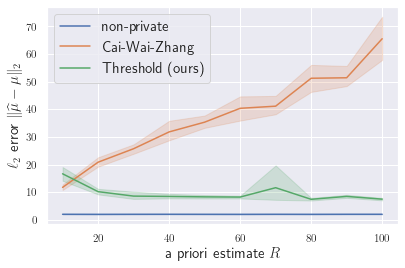

In [35]:
res_nonpriv = []
for R in Rs:
    res_nonpriv.append(get_l2_error(non_private_sparse_mean,
                                    R, n))
res_nonpriv = pd.concat(res_nonpriv, ignore_index=True)
sns.lineplot(x='R', y='l2_error',
             data=res_nonpriv,
             label='non-private')

res_cost_of_privacy = []
for R in Rs:
    res_cost_of_privacy.append(get_l2_error(cost_of_privacy_algorithm,
                                            R, n))
res_cost_of_privacy = pd.concat(res_cost_of_privacy, ignore_index=True)
sns.lineplot(x='R', y='l2_error', 
             data=res_cost_of_privacy,
             label='Cai-Wai-Zhang')

res_thresholding = []
for R in Rs:
    n_bins = int(0.5 * R / np.sqrt(np.log(n)))
    res_thresholding.append(get_l2_error(thresholded_peeling,
                                         R, n, num_bins_uni_est=n_bins))
res_thresholding = pd.concat(res_thresholding, ignore_index=True)
sns.lineplot(x='R', y='l2_error',
             data=res_thresholding,
             label='Threshold (ours)')

sns.set(font_scale=1, rc={'text.usetex' : True})
plt.xlabel('a priori estimate $R$', fontsize=15)
plt.ylabel('$\ell_2$ error $\|\widehat\mu - \mu\|_2$', fontsize=15)
plt.legend(fontsize=15)
sns.set(rc={'figure.figsize':(6.3, 4)})
plt.savefig('figures/l2_estimate_histogram.pdf')